In [49]:
from tqdm import tqdm
import pandas as pd

pd.set_option("display.max_columns", 500)
pd.set_option("display.max_rows", 500)


## Our role:

Consultant for "Delta Air Lines Inc."
We want to:

- Predict if a flight will be delayed or not at arrival
- Predict the delay time of a flight at arrival
- Find the most important possible recurrent reasons of delay

## inportant information

- target variables: Delayed (classification) and ArrDelayMinutes (regression)

## To Do

## Backup Ideas:

- airtime: compute the average for each trip?


In [61]:
df = pd.read_csv("../data/delta_combined_flights_2018_2022.csv")
df.drop(columns=["Airline"], inplace=True)

# Drop all the cancelled flights
# df = df[df['CANCELLED'] == 0]


In [51]:
df.head()

,FlightDate,Origin,Dest,DepTime,DepDelayMinutes,DepDelay,ArrDelayMinutes,AirTime,Distance,CRSElapsedTime,DayOfWeek,Year,Month,Tail_Number,Flight_Number_Operating_Airline,OriginAirportID,DestAirportID,DepDel15,DepartureDelayGroups,TaxiOut,CRSArrTime,ArrDelay,DistanceGroup
0,2018-01-27,ATL,ORF,1606.0,0.0,-2.0,0.0,73.0,516.0,95.0,6,2018,1,N923DL,1378,10397,13931,0.0,-1.0,8.0,1743,-13.0,3
1,2018-01-27,ATL,GSO,1656.0,0.0,-4.0,0.0,48.0,306.0,75.0,6,2018,1,N912DE,1380,10397,11995,0.0,-1.0,10.0,1815,-18.0,2
2,2018-01-27,TPA,MSP,716.0,0.0,-4.0,0.0,173.0,1306.0,207.0,6,2018,1,N699DL,1381,15304,13487,0.0,-1.0,15.0,947,-19.0,6
3,2018-01-27,LIH,LAX,2219.0,0.0,-6.0,7.0,311.0,2615.0,319.0,6,2018,1,N544US,1382,12982,12892,0.0,-1.0,17.0,544,7.0,11
4,2018-01-27,SMF,SLC,553.0,0.0,-7.0,0.0,73.0,532.0,103.0,6,2018,1,N3766,1384,14893,14869,0.0,-1.0,12.0,843,-19.0,3


In [62]:
# create categorical variables for night, morning, afternoon, evening based on DepTime
df["DepTime"] = df["DepTime"].astype(int)
df["TimeOfDay"] = df["DepTime"].apply(
    lambda x: "Night"
    if x < 600
    else "Morning"
    if x < 1200
    else "Afternoon"
    if x < 1800
    else "Evening"
    if x < 2400
    else "Night"
)

In [53]:
df.hist(column="DepTime", by="Delayed", bins=1000, figsize=(20, 10))

KeyError: 'Delayed'

<AxesSubplot: >

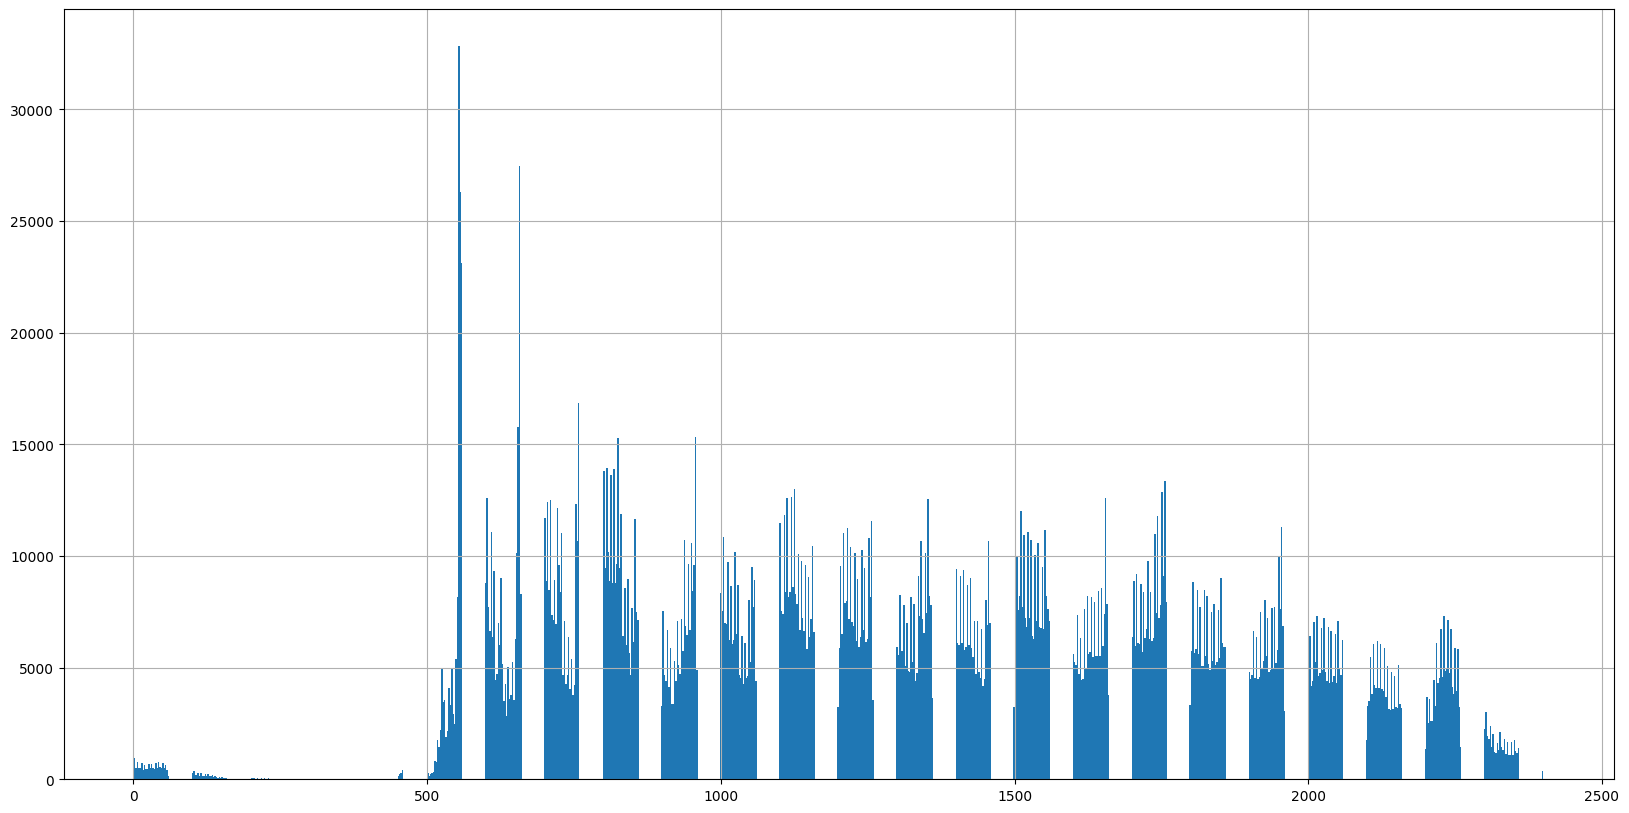

In [5]:
df["DepTime"].hist(bins=1000, figsize=(20, 10))

# plot a histogram of DepTime by separing Delayed and non Delayed flights


In [6]:
df["Delayed"].value_counts()
885704 / (885704 + 2356436)


0.2731849950958318

## Computing the average delay for one specific trip on the average of all previous flights.

`ArrDelayMinutes`


In [8]:
df

,FlightDate,Origin,Dest,DepTime,DepDelayMinutes,DepDelay,ArrDelayMinutes,AirTime,Distance,CRSElapsedTime,DayOfWeek,Year,Month,Tail_Number,Flight_Number_Operating_Airline,OriginAirportID,DestAirportID,DepDel15,DepartureDelayGroups,TaxiOut,CRSArrTime,ArrDelay,DistanceGroup,TimeOfDay,Delayed
26434,2018-01-01,LGA,ATL,757,0.0,-2.0,0.0,123.0,762.0,155.0,1,2018,1,N309US,1842,12953,10397,0.0,-1.0,15.0,1034,-13.0,4,Morning,False
26120,2018-01-01,LGA,MIA,704,0.0,-1.0,0.0,165.0,1096.0,203.0,1,2018,1,N945AT,1472,12953,13303,0.0,-1.0,16.0,1028,-14.0,5,Morning,False
26108,2018-01-01,LGA,RSW,1356,0.0,-9.0,0.0,186.0,1080.0,207.0,1,2018,1,N893AT,1456,12953,14635,0.0,-1.0,14.0,1732,-11.0,5,Afternoon,False
26100,2018-01-01,LGA,ATL,606,6.0,6.0,0.0,125.0,762.0,160.0,1,2018,1,N845DN,1447,12953,10397,0.0,0.0,16.0,840,-6.0,4,Morning,False
26069,2018-01-01,LGA,MIA,902,0.0,-3.0,0.0,158.0,1096.0,209.0,1,2018,1,N361NW,1415,12953,13303,0.0,-1.0,19.0,1234,-26.0,5,Morning,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2942818,2022-07-31,LGA,BOS,2242,43.0,43.0,27.0,41.0,184.0,77.0,7,2022,7,N131DU,2440,12953,10721,1.0,2.0,15.0,2316,27.0,1,Evening,True
2905952,2022-07-31,LGA,BOS,1558,0.0,-2.0,6.0,38.0,184.0,95.0,7,2022,7,N102DU,2067,12953,10721,0.0,-1.0,34.0,1735,6.0,1,Afternoon,True
2876674,2022-07-31,LGA,MSY,1057,0.0,-3.0,0.0,156.0,1183.0,211.0,7,2022,7,N134DU,1363,12953,13495,0.0,-1.0,31.0,1331,-22.0,5,Morning,False
2943155,2022-07-31,LGA,DTW,1305,10.0,10.0,0.0,77.0,502.0,121.0,7,2022,7,N117DU,2453,12953,11433,0.0,0.0,19.0,1456,-8.0,3,Afternoon,False


In [63]:
# Keep only flights departing from LGA
df = df[df["Origin"] == "LGA"]
len(df)

83168

In [55]:
# create a categorical variable saying whetere a flight is delayed or not
df["Delayed"] = df["DepDelay"] > 0

# sort by date
df = df.sort_values(by=["FlightDate"], ascending=True)
df_small = df[["Flight_Number_Operating_Airline", "DistanceGroup", "Tail_Number", "Dest", "DepDelayMinutes"]]

avgs_flight_number = []
avgs_distance_group = []
avgs_aircraft = []
avgs_origin = []

for i in tqdm(range(len(df_small))):

    row = df_small.iloc[i]
    flight_number = row["Flight_Number_Operating_Airline"]
    distance_group = row["DistanceGroup"]
    tail_number = row["Tail_Number"]
    destination = row["Dest"]
    data = df_small[0:i]

    ##### Average delay for each FlightNumber #####
    # data1 = data[data["Flight_Number_Operating_Airline"] == flight_number]
    avgs_flight_number.append(
        data[data["Flight_Number_Operating_Airline"] == flight_number][
            "DepDelayMinutes"
        ].mean()
    )

    ##### Average delay for each DistanceGroup #####
    # data2 = data[data["DistanceGroup"] == distance_group]
    avgs_distance_group.append(
        data[data["DistanceGroup"] == distance_group]["DepDelayMinutes"].mean()
    )

    ##### Average delay for each aircraft #####
    avgs_aircraft.append(
        data[data["Tail_Number"] == tail_number]["DepDelayMinutes"].mean()
    )

    ##### Average delay for each airport as DESTINATION #####
    # data4 = data[data["Dest"] == destination]
    avgs_origin.append(data[data["Dest"] == destination]
                       ["DepDelayMinutes"].mean())


# Saving results
df["AverageDelayPerFlightNumber"] = avgs_flight_number
df["AverageDelayPerDistanceGroup"] = avgs_distance_group
df["AverageDelayPerAircraft"] = avgs_aircraft
df["AverageDelayPerOrigin"] = avgs_origin

/var/folders/hk/nxk7bnsj4kq9nwsmnmdtzhb80000gn/T/ipykernel_8133/1399015836.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Delayed"] = df["DepDelay"] > 0
100%|██████████| 83168/83168 [06:34<00:00, 210.94it/s]


In [17]:
# df["AverageDelayPerFlightNumber"] = avgs_flight_number
# df["AverageDelayPerOrigin"] = avgs_origin

# B, C = avgs_distance_group[::2], avgs_distance_group[1::2]

# df["AverageDelayPerDistanceGroup"] = B
# df["AverageDelayPerAircraft"] = C

### 1. Compute the average delay for each year, for specific trip.

First, check if most trips have enough flights. We see here that only


<AxesSubplot: >

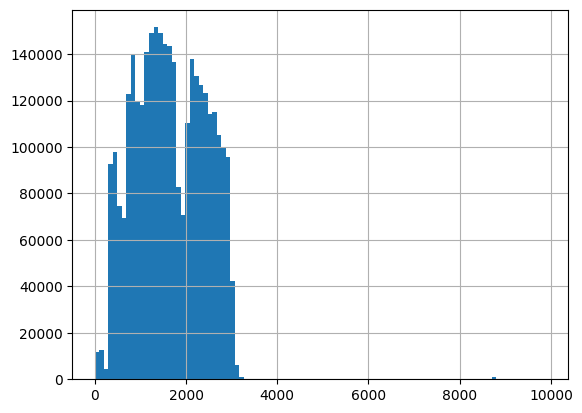

In [ ]:
df["Flight_Number_Operating_Airline"].hist(bins=100)


In [ ]:
print(len(df[df["Flight_Number_Operating_Airline"] < 25]))
print((1528 / len(df)))

1528

In [56]:
# # drop Tail_Number and Flight_Number_Operating_Airline and FlightDate
# df.drop(
#     columns=["Tail_Number", "Flight_Number_Operating_Airline", "FlightDate"],
#     inplace=True,
# )

In [57]:
data = df.copy(deep=True)


In [64]:
data["FlightDate"] = df["FlightDate"]

<AxesSubplot: >

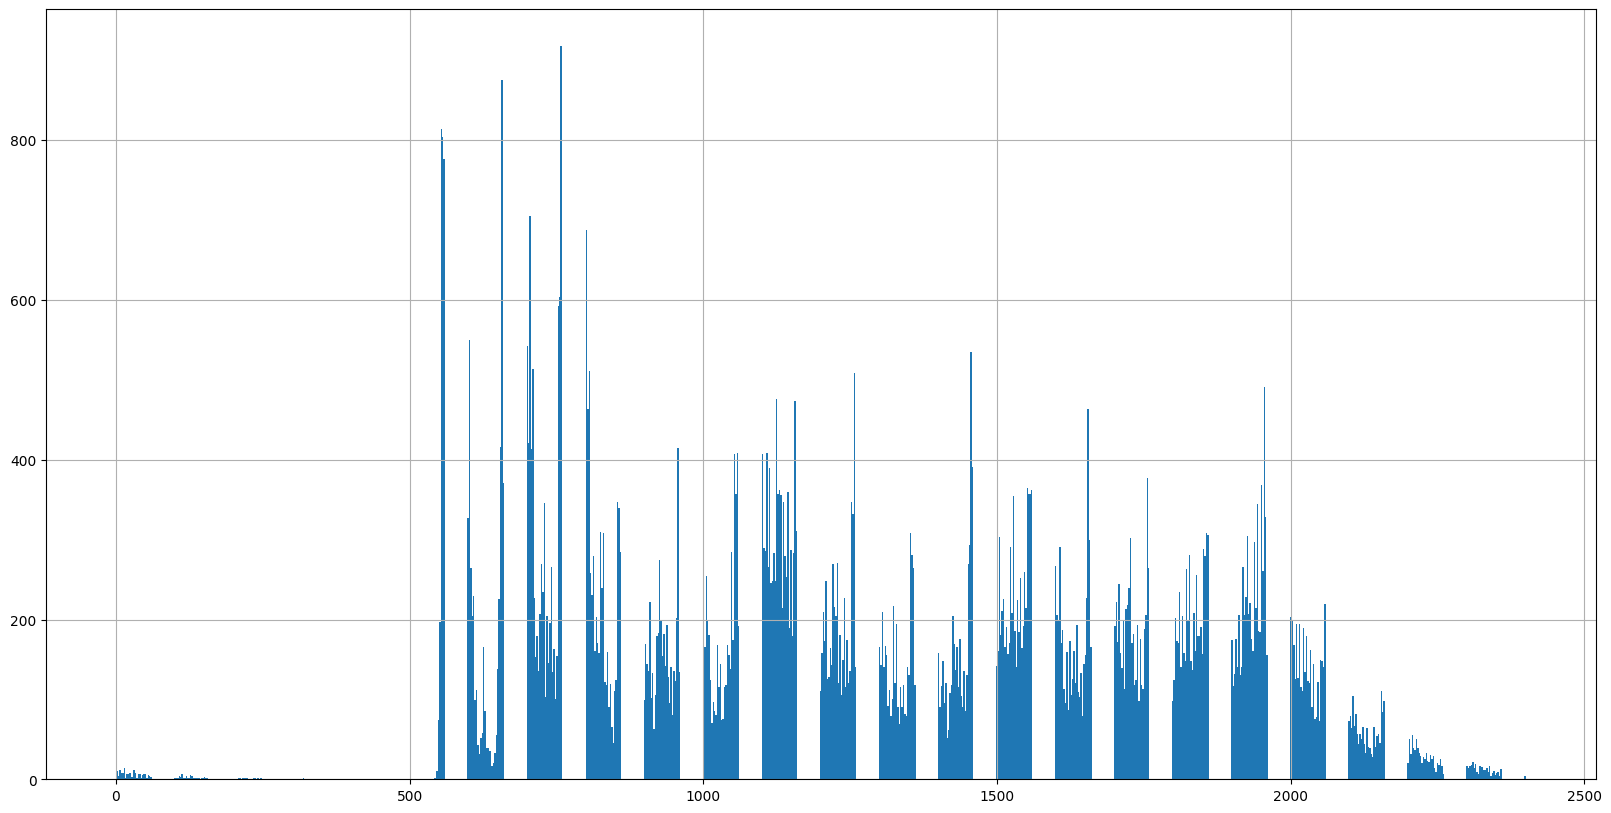

In [68]:
# show hist of DePtime
data["DepTime"].hist(bins=1000, figsize=(20, 10))

In [67]:
data.head()

,Origin,Dest,DepTime,DepDelayMinutes,DepDelay,ArrDelayMinutes,AirTime,Distance,CRSElapsedTime,DayOfWeek,Year,Month,OriginAirportID,DestAirportID,DepDel15,DepartureDelayGroups,TaxiOut,CRSArrTime,ArrDelay,DistanceGroup,TimeOfDay,Delayed,AverageDelayPerFlightNumber,AverageDelayPerDistanceGroup,AverageDelayPerAircraft,AverageDelayPerOrigin,FlightDate
26434,LGA,ATL,757,0.0,-2.0,0.0,123.0,762.0,155.0,1,2018,1,12953,10397,0.0,-1.0,15.0,1034,-13.0,4,Morning,False,NaN,NaN,NaN,NaN,2018-01-01
26120,LGA,MIA,704,0.0,-1.0,0.0,165.0,1096.0,203.0,1,2018,1,12953,13303,0.0,-1.0,16.0,1028,-14.0,5,Morning,False,NaN,NaN,NaN,NaN,2018-01-01
26108,LGA,RSW,1356,0.0,-9.0,0.0,186.0,1080.0,207.0,1,2018,1,12953,14635,0.0,-1.0,14.0,1732,-11.0,5,Afternoon,False,NaN,0.0,NaN,NaN,2018-01-01
26100,LGA,ATL,606,6.0,6.0,0.0,125.0,762.0,160.0,1,2018,1,12953,10397,0.0,0.0,16.0,840,-6.0,4,Morning,True,NaN,0.0,NaN,0.0,2018-01-01
26069,LGA,MIA,902,0.0,-3.0,0.0,158.0,1096.0,209.0,1,2018,1,12953,13303,0.0,-1.0,19.0,1234,-26.0,5,Morning,False,NaN,0.0,NaN,0.0,2018-01-01


In [65]:
df = data.copy(deep=True)

In [66]:
df = df.fillna(0)

# transform as category
# df["Origin"] = df["Origin"].astype("category")
# df["Dest"] = df["Dest"].astype("category")

df["DepTimeMinutes"] = df["DepTime"].apply(lambda x: int(x / 100) * 60 + x % 100)
df["CRSDepTime"] = df["DepTimeMinutes"] - df["DepDelay"]
df["CRSArrTime"] = df["CRSArrTime"].apply(lambda x: int(x / 100) * 60 + x % 100)
df["CRSElapsedTime"] = df["CRSElapsedTime"].apply(lambda x: int(x / 100) * 60 + x % 100)

features = [
    "FlightDate",
    "DepDelay",
    "Distance",
    "Origin",
    "Dest",
    "CRSDepTime",
    "CRSElapsedTime",
    "CRSArrTime",
    "DayOfWeek",
    "Year",
    "Month",
    #"Tail_Number",
    "AverageDelayPerFlightNumber",
    "AverageDelayPerDistanceGroup",
    "AverageDelayPerAircraft",
]

# split the dataset based on the FlightDate for october 2019
data_regression = df[features]
data_regression.head()

#drop the origin column
data_regression.drop(columns=["Origin"], inplace=True)

# transform categorical features into dummy variables
data_regression = pd.get_dummies(data_regression, columns=["Dest"], dtype="int")#, "Tail_Number"])

# # # Substract Origin_ABE from Dest_ABE
# airports = df["Origin"].unique()
# for airport in tqdm(airports):
#     data_regression[f"Origin_{airport}"].astype("float")   
#     data_regression[f"Dest_{airport}"].astype("float")   
#     data_regression[airport] = data_regression[f"Origin_{airport}"] - data_regression[f"Dest_{airport}"]
#     data_regression.drop([f"Origin_{airport}", f"Dest_{airport}"], axis=1, inplace=True)

data_regression.head(10)

/var/folders/hk/nxk7bnsj4kq9nwsmnmdtzhb80000gn/T/ipykernel_8133/3776199242.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_regression.drop(columns=["Origin"], inplace=True)


,FlightDate,DepDelay,Distance,CRSDepTime,CRSElapsedTime,CRSArrTime,DayOfWeek,Year,Month,AverageDelayPerFlightNumber,AverageDelayPerDistanceGroup,AverageDelayPerAircraft,Dest_ALB,Dest_ATL,Dest_BNA,Dest_BOS,Dest_BUF,Dest_BZN,Dest_CHS,Dest_CLT,Dest_CMH,Dest_CVG,Dest_DCA,Dest_DEN,Dest_DFW,Dest_DTW,Dest_FLL,Dest_GSP,Dest_IAH,Dest_JAX,Dest_MCO,Dest_MHT,Dest_MIA,Dest_MSN,Dest_MSP,Dest_MSY,Dest_MYR,Dest_OMA,Dest_ORD,Dest_ORF,Dest_PBI,Dest_PWM,Dest_RDU,Dest_RIC,Dest_RSW,Dest_SDF,Dest_SRQ,Dest_STL,Dest_TPA,Dest_TVC
26434,2018-01-01,-2.0,762.0,479.0,115.0,634,1,2018,1,0.0,0.0,0.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
26120,2018-01-01,-1.0,1096.0,425.0,123.0,628,1,2018,1,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
26108,2018-01-01,-9.0,1080.0,845.0,127.0,1052,1,2018,1,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
26100,2018-01-01,6.0,762.0,360.0,120.0,520,1,2018,1,0.0,0.0,0.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
26069,2018-01-01,-3.0,1096.0,545.0,129.0,754,1,2018,1,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
26052,2018-01-01,0.0,950.0,925.0,149.0,1114,1,2018,1,0.0,3.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
26032,2018-01-01,-6.0,950.0,486.0,147.0,673,1,2018,1,0.0,2.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
26006,2018-01-01,-2.0,762.0,1020.0,129.0,1189,1,2018,1,0.0,1.5,0.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
25999,2018-01-01,28.0,1096.0,615.0,132.0,827,1,2018,1,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
25810,2018-01-01,11.0,1076.0,710.0,159.0,909,1,2018,1,0.0,7.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [69]:
# keep values of 2018 and 2019
data_regression = data_regression[(data_regression["Year"] >= 2018) & (data_regression["Year"] <= 2019)]
data_regression["Year"].value_counts()

2019    28080
2018    11344
Name: Year, dtype: int64

In [70]:
data_regression.to_csv("../data/LGA_Flights_Departure.csv", index=False)

# Split the data into train and test set
